# Compare relative phase shifts between NR and XPHM/XHM 

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
#
from positive import *
from matplotlib.pyplot import *
#
from numpy import *
from numpy.fft import ifft,fftshift,fftfreq,fft
from glob import glob as find
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
from nrutils.core.basics import *
from nrutils import scsearch,gwylm
#
from lalsimulation import SimInspiralChooseFDWaveform
import lalsimulation as lalsim
#
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


In [2]:
#
datadir = '/Users/book/KOALA/PhenomXCP/data/version4/'
data_path = datadir+'calibration_data_dict.pickle'
calibration_data_dict = pickle.load( open( data_path, "rb" ) )

In [3]:
#
phenomhm_dphi0 = lambda l,m: (1/2) * ( 3*l + mod(l+m,2) ) -1

{  (l,m):exp( 1j*pi*phenomhm_dphi0(l,m) ) for l,m in [ (2,2),(3,3),(4,4),(2,1),(3,2),(4,3) ] }

{(2, 2): (1-2.4492935982947064e-16j),
 (3, 3): (-4.286263797015736e-16-1j),
 (4, 4): (-1+6.123233995736766e-16j),
 (2, 1): (3.061616997868383e-16+1j),
 (3, 2): (1-4.898587196589413e-16j),
 (4, 3): (-2.4499125789312946e-15-1j)}

In [33]:
#
bam_id = 'q8a08t120'
# bam_id = 'q8a08t90'
# bam_id = 'q8a06t150'
a = scsearch(keyword=bam_id,verbose=True,catalog=calibration_catalog)[-1]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q8a08t120) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 1 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.80-p-q8.00	(q8a08t120dP2_r03_T_96_360)



In [34]:
# Get metadata for case. The spins here are in the "LAL" frame
# ---

#
k = [ k for k,simname in enumerate(metadata_dict['simname']) if simname in a.simname ][0]

# Collect params for this case 
theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z,Mf,Xf = metadata_dict['array_data'][k,:]

# chi1_vec = array([chi1_y,chi1_x,chi1_z])
# chi2_vec = array([chi2_y,chi2_x,chi2_z])

chi1_vec = array([chi1_x,chi1_y,chi1_z])
chi2_vec = array([chi2_x,chi2_y,chi2_z])

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* #
# Load data that has been processed in issue 3c
# ---
ll = mm = 2
(metadata,f,dphi_fd,amp_fd,xphm_dphi,dphi_fd_enforced_min,nr_dphi_lm_shift,min_xphm_dphi_l2m2) = calibration_data_dict[ll,mm][a.simname]
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* #


In [35]:
print(chi1_vec)
print(chi2_vec)

[ 8.10327490e-07  6.89199969e-01 -4.06177973e-01]
[0. 0. 0.]


In [36]:
# #
# y = gwylm(a,lmax=4,clean=True,verbose=False,dt=0.5,pad=1000)

In [37]:
# frame = {}
# frame['raw'] = y
# frame['init-j'] = y.__calc_initial_j_frame__()
# frame['j-of-t'] = frame['init-j'].__calc_j_of_t_frame__()
# frame['psi4-td-cp'] = frame['init-j'].__calc_coprecessing_frame__(kind='psi4',transform_domain='td',verbose=True)

In [38]:
#
# frame['strain-td-cp'] = frame['init-j'].__calc_coprecessing_frame__(kind='strain',transform_domain='td',verbose=True)

In [39]:
def get_xphm_coprecessing_phase( ell, emm, q, chi1, chi2, phiRef=0.0, use_pnr=True):
    
    #
    Mtotal = 100.0

    m1_SI = Mtotal * q / (1.0 + q) * lal.MSUN_SI 
    m2_SI = Mtotal / (1.0 + q) * lal.MSUN_SI 

    # generate co-precessing waveform
    lalparams = lal.CreateDict( )
    lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lalparams, 0)
    lalsim.SimInspiralWaveformParamsInsertPhenomXPHMPrecModes(lalparams, 1)

    if use_pnr:
        lalsim.SimInspiralWaveformParamsInsertPhenomXPrecVersion(lalparams, 500);

    distance = 1e6*lal.PC_SI 

    delta_F=0.125 
    f_lower=5.
    fRef=20.
    f_max = 512.

    freqs = np.linspace(f_lower, f_max, int((f_max-f_lower)/delta_F))

    S1x, S1y, S1z = chi1 
    S2x, S2y, S2z = chi2 

    phase = lalsim.SimIMRPhenomXHMPhase(
                    freqs,
                    ell, emm,
                    m1_SI, m2_SI,
                    S1x, S1y, S1z,
                    S2x, S2y, S2z,
                    distance,
                    phiRef,
                    fRef,
                    lalparams
                )
    
    freqs = codef(freqs,Mtotal)
    strain_phase = phase.data
    

    return freqs, strain_phase

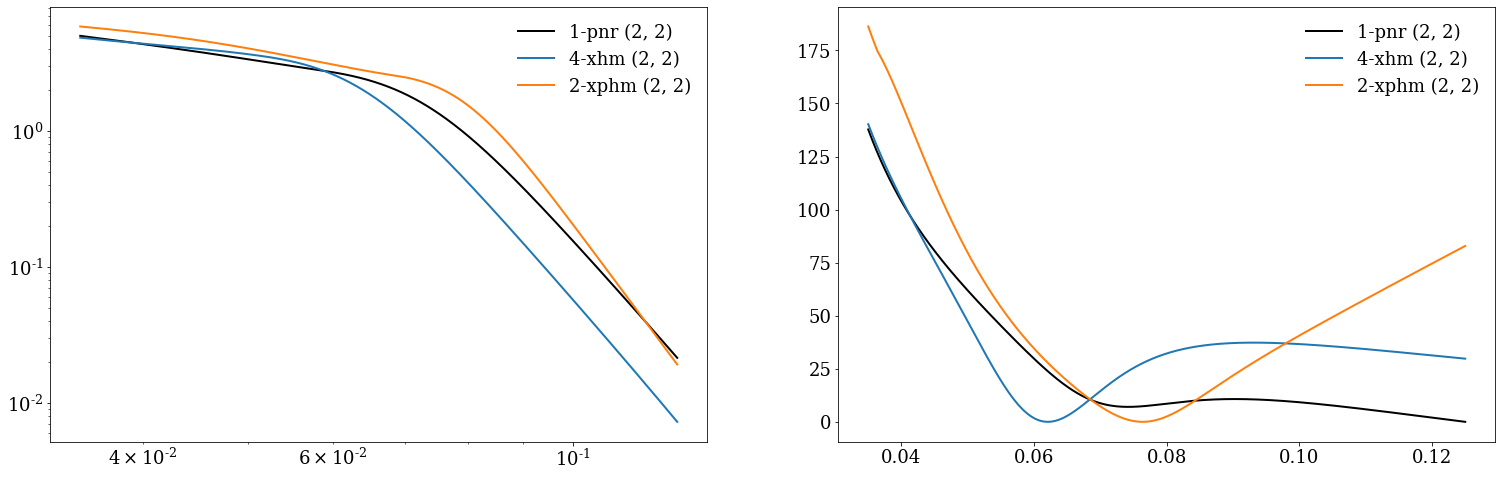

In [40]:
lmlist = [(2,2)]
ff = linspace(0.035,0.125,1e4)

#
fig,ax = subplots(1,2,figsize=2*figaspect(0.618/2))
lw = 2
opts = ['1-pnr','4-xhm','2-xphm']
cs = ['k','tab:blue','tab:orange']

c = { opts[k]:cs[k] for k in range(len(opts)) }

#
ax = ax.flatten()

for opt in opts:

    phenom_moments_dict = xcp.get_phenomxphm_coprecessing_multipoles( ff,lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=opt ) 

    #
    for k in lmlist:
        
        #
        h = phenom_moments_dict[k]
        
        #
        amp = abs(h)
        phi = unwrap( angle(h) )
        dphi_raw = spline_diff( ff, phi )
        dphi = dphi_raw - min(dphi_raw)
        
        #
        sca( ax[0] )
        plot( ff, amp, lw=lw, label=opt+' %s'%str(k), c = c[opt] )
        xscale('log')
        yscale('log')
        
        #
        sca( ax[1] )
        plot( ff, dphi, lw=lw, label=opt+' %s'%str(k), c = c[opt] )
    
    
sca(ax[0])
legend()
sca(ax[1])
legend()
    
#     #
#     h22 = mod_xhm_dict_b[2,2]
    
#     #
#     dphi[opt] = phi_33-scaled_phi_22
    
#     #
#     k = find(ff>=min(f))[0]
#     flat_val = dphi[opt][k] 
    
#     #
#     dphi[opt] += -dphi[opt][k] + mod(flat_val,2*pi)

#     #
#     plot(ff,dphi[opt],lw=1,label=opt.split('-')[-1].upper())
# #     plot(ff,dphi[opt]+(7 if 'pnr' in opt else 0),lw=1,label=opt.split('-')[-1].upper())
#     x0,x1 = xlim(lim(f,dilate=0.1))
# #     xlim(x0,1.5*x0)
    
#     y0_,y1_ = limy(ff,dphi[opt],dilate=0.2)
#     y0 = min(y0,y0_)
#     y1 = max(y1,y1_)
    
# #
# xlabel('$fM$'); ylabel(r'$\Psi_{33}(f)-\frac{3}{2}\Psi_{22}(\frac{2}{3} f )$')
# axvline(min(f),ls='--',c='k',label='Calibration $f_{min}$ and $f_{max}$')
# axvline(max(f),ls='--',c='k')
# axhline(0,c='k',ls=':')
# # xscale('log')
# # ylim(y0,y1)

# x0,x1 = xlim(lim(ff,dilate=0.1))
# # print(lim(f,dilate=0.1))

# # xlim(x0,1.5*x0)
# # xlim(min(ff),2e-2)
# # xlim(0.005,0.0075)
# axhline( mod(-(3.0/4)*pi*(1-3.0/2),2*pi),c='k',alpha=0.25 ,ls='--',lw=2,zorder=-10)
# print('>>', (3.0/4)*pi*(1-3.0/2))
# legend();

# title('%s: No PNR TimeShift; XPHM shows the issue'%a.simname,size=16);


In [41]:
# fqs33,phi33_a = get_xphm_coprecessing_phase(3,3,m1/m2,array([chi1_x,chi1_y,chi1_z]),zeros(3))
# fqs22,phi22_a = get_xphm_coprecessing_phase(2,2,m1/m2,array([chi1_x,chi1_y,chi1_z]),zeros(3))

# phi33_b = spline(fqs33,phi33_a)(fqs22*2.0/3)

In [42]:
# plot(fqs33,phi33_a)
# plot(fqs22*2.0/3,phi22_a*1.5)
# xlim( lim(fqs22*2.0/3) )

0>> falign = 0.014650
*>> falign = 0.014650
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.014650
*>> falign = 0.014650
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

-->  4.472790476989626
0>> falign = 0.014650
*>> falign = 0.014650
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.014650
*>> falign = 0.014650
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

-->  4.574032076001583
0>> falign = 0.014650
*>> falign = 0.014650
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.014650
*>> falign = 0.014650
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

-->  1.300684375962362
>> -1.1780972450961724


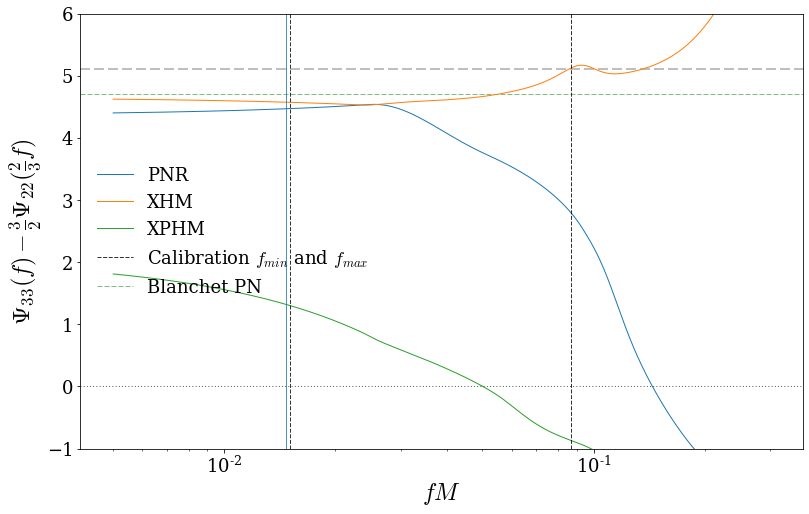

In [47]:
lmlist = [(2,2),(3,3)]
ff = linspace(0.005,0.3,5e4)

#
figure(figsize=2*figaspect(0.618))

dphi = {}

#
y0 = inf
y1 = 0
for opt in ['1-pnr','4-xhm','2-xphm']:

    mod_xhm_dict_a = xcp.get_phenomxphm_coprecessing_multipoles( ff,lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=opt ) 
    mod_xhm_dict_b = xcp.get_phenomxphm_coprecessing_multipoles( ff*(2.0/3),lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=opt ) # 4-xhm 2-xphm

    #
    center = lambda x: x - mean(x) + mod(mean(x),2*pi)
    
    #
    mod_xhm = mod_xhm_dict_b[2,2]
    scaled_phi_22  = (3.0/2) * center(unwrap( angle(mod_xhm) ))
    #
    mod_xhm = mod_xhm_dict_a[3,3]
    phi_33 = center(unwrap( angle(mod_xhm) ))

#     #
#     mod_xhm = mod_xhm_dict_b[2,2]
#     unscaled_phi_22 = unwrap( angle(mod_xhm) )
#     unscaled_phi_22 = unscaled_phi_22 - max(unscaled_phi_22) + mod(max(unscaled_phi_22),2*pi)
#     scaled_phi_22  = (3.0/2) * unscaled_phi_22
#     #
#     mod_xhm = mod_xhm_dict_a[3,3]
#     phi_33 = unwrap( angle(mod_xhm) )
#     phi_33 = phi_33 - max(phi_33) + mod(max(phi_33),2*pi)
    
    #
    dphi[opt] = phi_33-scaled_phi_22
    
    #
    k = find(ff>=min(f))[0]
    flat_val = dphi[opt][k] 
#     axhline(mod(flat_val,2*pi),color='r')
    print('--> ',mod(flat_val,2*pi))
    
#     #
#     k = 0
#     flat_val = dphi[opt][k] 
#     axhline(mod(flat_val,2*pi),color='r')
#     print('--> ',mod(flat_val,2*pi))
    
    #
    dphi[opt] += -dphi[opt][k] + mod(flat_val,2*pi)

    #
#     plot(ff,spline_diff(ff,dphi[opt]),lw=1,label=opt.split('-')[-1].upper())
    plot(ff,dphi[opt],lw=1,label=opt.split('-')[-1].upper())
    
#     plot(ff,dphi[opt]+(7 if 'pnr' in opt else 0),lw=1,label=opt.split('-')[-1].upper())
    # x0,x1 = xlim(lim(f,dilate=0.1))
#     xlim(x0,1.5*x0)
    
    y0_,y1_ = limy(ff,dphi[opt],dilate=0.2)
    y0 = min(y0,y0_)
    y1 = max(y1,y1_)
    
#
xlabel('$fM$'); ylabel(r'$\Psi_{33}(f)-\frac{3}{2}\Psi_{22}(\frac{2}{3} f )$')
axvline(min(f),ls='--',c='k',label='Calibration $f_{min}$ and $f_{max}$')
axvline(max(f),ls='--',c='k')
axhline(0,c='k',ls=':')
# xscale('log')
# ylim(y0,y1)

# x0,x1 = xlim(lim(ff,dilate=0.1))
# print(lim(f,dilate=0.1))

# xlim(x0,1.5*x0)
# xlim(min(ff),2e-2)
# xlim(0.005,0.0075)
axhline( mod((3.0/4)*pi*(1-3.0/2),2*pi),c='k',alpha=0.25 ,ls='--',lw=2,zorder=-10)

axhline( mod(-pi*0.5,2*pi),c='g',alpha=0.5 ,ls='--',lw=1,zorder=-10, label='Blanchet PN')

print('>>', (3.0/4)*pi*(1-3.0/2))
legend();
xscale('log')

ylim(-1,6)

axvline(0.014650)

# title('%s: No PNR TimeShift; XPHM shows the issue'%a.simname,size=16);

0>> falign = 0.013933
*>> falign = 0.013933
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.013933
*>> falign = 0.013933
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.013933
*>> falign = 0.013933
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.013933
*>> falign = 0.013933
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.013933
*>> falign = 0.013933
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

0>> falign = 0.013933
*>> falign = 0.013933
*>> relative_phase_at_zero_freq = -1.178097
*>> m_over_2 = 1.500000

>> -1.1780972450961724


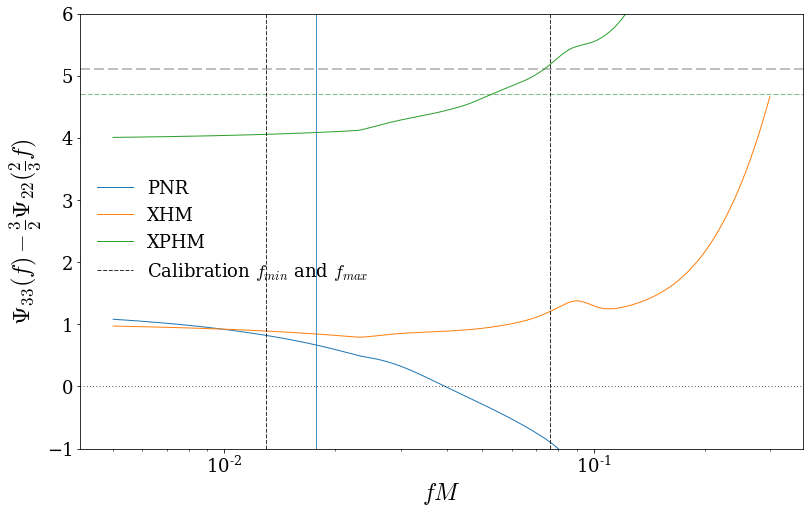

In [31]:
lmlist = [(2,2),(3,3)]
ff = linspace(0.005,0.3,5e4)

#
figure(figsize=2*figaspect(0.618))

dphi = {}

#
y0 = inf
y1 = 0
for opt in ['1-pnr','4-xhm','2-xphm']:

    mod_xhm_dict_a = xcp.get_phenomxphm_coprecessing_multipoles( ff,lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=opt ) 
    mod_xhm_dict_b = xcp.get_phenomxphm_coprecessing_multipoles( ff*(2.0/3),lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand=opt ) # 4-xhm 2-xphm

    #
    center = lambda x: x - mean(x) + mod(mean(x),2*pi)
    
    #
    mod_xhm = mod_xhm_dict_b[2,2]
    scaled_phi_22  = (3.0/2) * center(unwrap( angle(mod_xhm) ))
    #
    mod_xhm = mod_xhm_dict_a[3,3]
    phi_33 = center(unwrap( angle(mod_xhm) ))

#     #
#     mod_xhm = mod_xhm_dict_b[2,2]
#     unscaled_phi_22 = unwrap( angle(mod_xhm) )
#     unscaled_phi_22 = unscaled_phi_22 - max(unscaled_phi_22) + mod(max(unscaled_phi_22),2*pi)
#     scaled_phi_22  = (3.0/2) * unscaled_phi_22
#     #
#     mod_xhm = mod_xhm_dict_a[3,3]
#     phi_33 = unwrap( angle(mod_xhm) )
#     phi_33 = phi_33 - max(phi_33) + mod(max(phi_33),2*pi)
    
    #
    dphi[opt] = phi_33-scaled_phi_22
    
    #
    k = find(ff>=min(f))[0]
    flat_val = dphi[opt][k] 
    
    #
    dphi[opt] += -dphi[opt][k] + mod(flat_val,2*pi)

    #
#     plot(ff,spline_diff(ff,dphi[opt]),lw=1,label=opt.split('-')[-1].upper())
    plot(ff,dphi[opt],lw=1,label=opt.split('-')[-1].upper())
    
#     plot(ff,dphi[opt]+(7 if 'pnr' in opt else 0),lw=1,label=opt.split('-')[-1].upper())
    # x0,x1 = xlim(lim(f,dilate=0.1))
#     xlim(x0,1.5*x0)
    
    y0_,y1_ = limy(ff,dphi[opt],dilate=0.2)
    y0 = min(y0,y0_)
    y1 = max(y1,y1_)
    
#
xlabel('$fM$'); ylabel(r'$\Psi_{33}(f)-\frac{3}{2}\Psi_{22}(\frac{2}{3} f )$')
axvline(min(f),ls='--',c='k',label='Calibration $f_{min}$ and $f_{max}$')
axvline(max(f),ls='--',c='k')
axhline(0,c='k',ls=':')
# xscale('log')
# ylim(y0,y1)

# x0,x1 = xlim(lim(ff,dilate=0.1))
# print(lim(f,dilate=0.1))

# xlim(x0,1.5*x0)
# xlim(min(ff),2e-2)
# xlim(0.005,0.0075)
axhline( mod((3.0/4)*pi*(1-3.0/2),2*pi),c='k',alpha=0.25 ,ls='--',lw=2,zorder=-10)

axhline( mod(-pi*0.5,2*pi),c='g',alpha=0.5 ,ls='--',lw=1,zorder=-10)

print('>>', (3.0/4)*pi*(1-3.0/2))
legend();
xscale('log')

ylim(-1,6)

axvline(0.017701)

# title('%s: No PNR TimeShift; XPHM shows the issue'%a.simname,size=16);

In [39]:
# double deltaphiLM =  m_over_2*(
#                                 1./pWF22->eta*IMRPhenomX_Phase_22(two_over_m*falign, &powers_of_f,pPhase22,pWF22)
#                                 +pWFHM->phaseshift 
#                                 + pWFHM->phiref22
#                               )
#                      +pWFHM->timeshift*falign
#                      -3.*LAL_PI_4*(1-m_over_2)
#                      -(IMRPhenomXHM_Inspiral_Phase_AnsatzInt(falign, &powers_of_falign,pPhase)+pPhase->C1INSP*falign+pPhase->CINSP);

In [19]:


# y = frame['strain-td-cp']
# phi_22 = y[2,2]['psi4'].fd_phi
# phi_33 = y[3,3]['psi4'].fd_phi

# d_phi = phi_22-phi_33
# plot( y.f, d_phi )
# x0 = 1.3*y.wstart/(2*pi)
# x1 = 0.3
# xlim( lim(f) )
# ylim( limy(y.f,d_phi) )


In [20]:
# def get_lalsim_msa_angles( ell, f, m1, m2, X1_vec, X2_vec, f_ref=0 ):
    
#     '''Wrapper for lalsim.SimIMRPhenomXPMSAAngles'''
    
#     #
#     import lalsimulation as lalsim
#     import lal
#     from positive.units import codef,codeh,codehf,physf
#     from positive import error
    
#     #
#     if min(f)<0:
#         error('frequencies must be positive')
    
#     #
#     Msol = 100.0
#     m1_SI = lal.MSUN_SI * m1 * Msol/ ( m1 + m2 )
#     m2_SI = lal.MSUN_SI * m2 * Msol/ ( m1 + m2 )
    
#     # Create physical frequencies as a LAL REAL* sequence
#     freqs_Hz = lal.CreateREAL8Sequence( len(f) )
#     freqs_Hz.data = physf(f,Msol)
    
#     #
#     lalparams = lal.CreateDict()
# #     ModeArray = lalsim.SimInspiralCreateModeArray()
# #     lalsim.SimInspiralModeArrayActivateMode(ModeArray, ell,ell)
# #     lalsim.SimInspiralWaveformParamsInsertModeArray(lalparams, ModeArray)

# #     # Turn off multibanding
# #     lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lalparams, 0)
# #     lalsim.SimInspiralWaveformParamsInsertPhenomXPHMThresholdMband(lalparams, 0)
    
#     #
#     f_hz = physf(f,Msol)
#     fmin,fmax = lim(f_hz)
#     df = f_hz[1]-f_hz[0]
    
#     print( fmin,fmax )
    
#     # NOTE that LAL's actual fmin will be min(f_hz)+df
#     u = mod( len(f),2 ) #== 0
#     alert(u)
    
#     # XLALSimIMRPhenomX_PNR_GeneratePNRAnglesHM
#     foo = lalsim.SimIMRPhenomX_PNR_GenerateMSAAngles( m1_SI,
#                                                       m2_SI,
#                                                       X1_vec[0],X1_vec[1],X1_vec[2],
#                                                       X2_vec[0],X2_vec[1],X2_vec[2],
#                                                       df,fmin+u*df,fmax+u*df,f_ref,
#                                                       ell,lalparams )
    
#     # 
#     bar = lalsim.SimIMRPhenomX_PNR_GeneratePNRAnglesHM( m1_SI,
#                                                       m2_SI,
#                                                       X1_vec[0],X1_vec[1],X1_vec[2],
#                                                       X2_vec[0],X2_vec[1],X2_vec[2],
#                                                       df,fmin+u*df,fmax+u*df,f_ref,
#                                                       ell,ell,lalparams )
#     #
#     foo = [ k.data for k in foo ]
#     bar = [ (k if isinstance(k,float) else k.data)  for k in bar ]
    
#     #
#     alpha,beta,gamma,f_lal = foo
#     alpha_pnr,beta_pnr,gamma_pnr,f_lal,alpha_ref,gamma_ref = bar
    
#     #
#     alpha_pnr -= alpha_ref
#     gamma_pnr -= gamma_ref
    
#     #
#     alpha,beta,gamma = [ unwrap(mod(k,2*pi)) for k in (alpha,beta,gamma) ]
    
#     # 
#     f_lal = codef( f_lal, Msol )
#     if sum(abs(f-f_lal))>1e-10:
#         print( lim(f) )
#         print( lim(f_lal) )
#         print( len(f) )
#         print(sum(abs(f-f_lal)))
#         error('Frequency series much match between whats input, and what lal generates internally')
#     # else:
#     #     print(sum(abs(f-f_lal)))
    
#     #
#     return alpha,beta,gamma, alpha_pnr,beta_pnr,gamma_pnr
    

In [21]:
# f = y.f[ (y.f>=y.wstart/(2*pi)) & (y.f<=2*y[2,2]['psi4'].qnm_prograde_fring) ]
# ell = 2

# # I think that I should be interested in the fref=0 behavior here
# alpha,beta,gamma, alpha_pnr,beta_pnr,gamma_pnr = get_lalsim_msa_angles( ell, f, y.m1, y.m2, chi1_vec, chi2_vec, f_ref=20 )
# # alpha,beta,gamma = get_lalsim_msa_angles( ell, f, y.m1, y.m2, chi1_vec, chi2_vec, f_ref=0 )

In [22]:
# chi2_vec

In [23]:
# figure(figsize=2*figaspect(0.618))
# lw=2

# # plot( f,alpha, label='msa alpha', lw=lw )
# # plot( f,alpha_pnr+2*pi, label='PNR alpha', lw=lw )
# # plot( f,beta )
# plot( f,gamma, label='msa gamma' )

# # plot( f,alpha2, ls='--' )
# # plot( f,beta2, ls='--' )
# plot( f,gamma_pnr, ls='-',label='gamma PNR' )

# my_gamma = spline_antidiff(f, -cos(beta_pnr) * spline_diff(f,alpha_pnr) )
# plot( f, my_gamma - my_gamma[0] + gamma[0], '-', label='Minimal rotation gamma' )
# legend()

# xlabel('$fM$')
# title(a.simname)

In [24]:
# plot( y.f, frame['strain-td-cp'][2,2]['strain'].fd_amp )
# yscale('log')
# xscale('log')
# axvline( y.wstart/(2*pi),c='k',ls=':' )
# axvline( y[2,2]['psi4'].qnm_prograde_fring ,c='k',ls=':')

In [25]:

# #
# t = y.t

# #
# plot( t, frame['psi4-td-cp'][2,2]['strain'].phi, c='tab:blue', ls='-' )
# plot( t, frame['psi4-td-cp'][3,3]['strain'].phi, c='tab:blue', ls='--' )

# #
# plot( t, frame['strain-td-cp'][2,2]['strain'].phi, c='tab:orange', ls='-' )
# plot( t, frame['strain-td-cp'][3,3]['strain'].phi, c='tab:orange', ls='--' )


In [26]:

# #
# t = y.t

# #
# A = frame['psi4-td-cp'][2,2]['strain'].phi-frame['strain-td-cp'][2,2]['strain'].phi
# B = frame['psi4-td-cp'][3,3]['strain'].phi-frame['strain-td-cp'][3,3]['strain'].phi

# #
# plot( t, A, c='tab:blue', ls='-' )
# plot( t, B, c='tab:blue', ls='--' )

# xlim(0,2100)
# ylim( limy(t,A) )